In [905]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [906]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [907]:
label = "all"
folder_path = f"/export/home/wuyueting/breast_data/BM/3_labelcroped/test/"
model_name = "breast_rn50_3"
target_layer="model.resnet.layer4[-1]"#"model.resnet.layer4[-1]" #"model.blocks[-1].mlp.act"
target_save_name = model_name+target_layer

activs_stats/breast_rn50_3model.resnet.layer4[-1]/all.pkl exist!
activs_stats/breast_rn50_3model.resnet.layer4[-1]/all.pkl
Draw bar chart for label all...
Draw Finish! in matching_result/breast_rn50_3model.resnet.layer4[-1]/all/weight_plot.png
Draw Finish! in matching_result/breast_rn50_3model.resnet.layer4[-1]/all/activation_plot.png
predict_result/breast_rn50_3_predictions.csv exist!


<Figure size 640x480 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

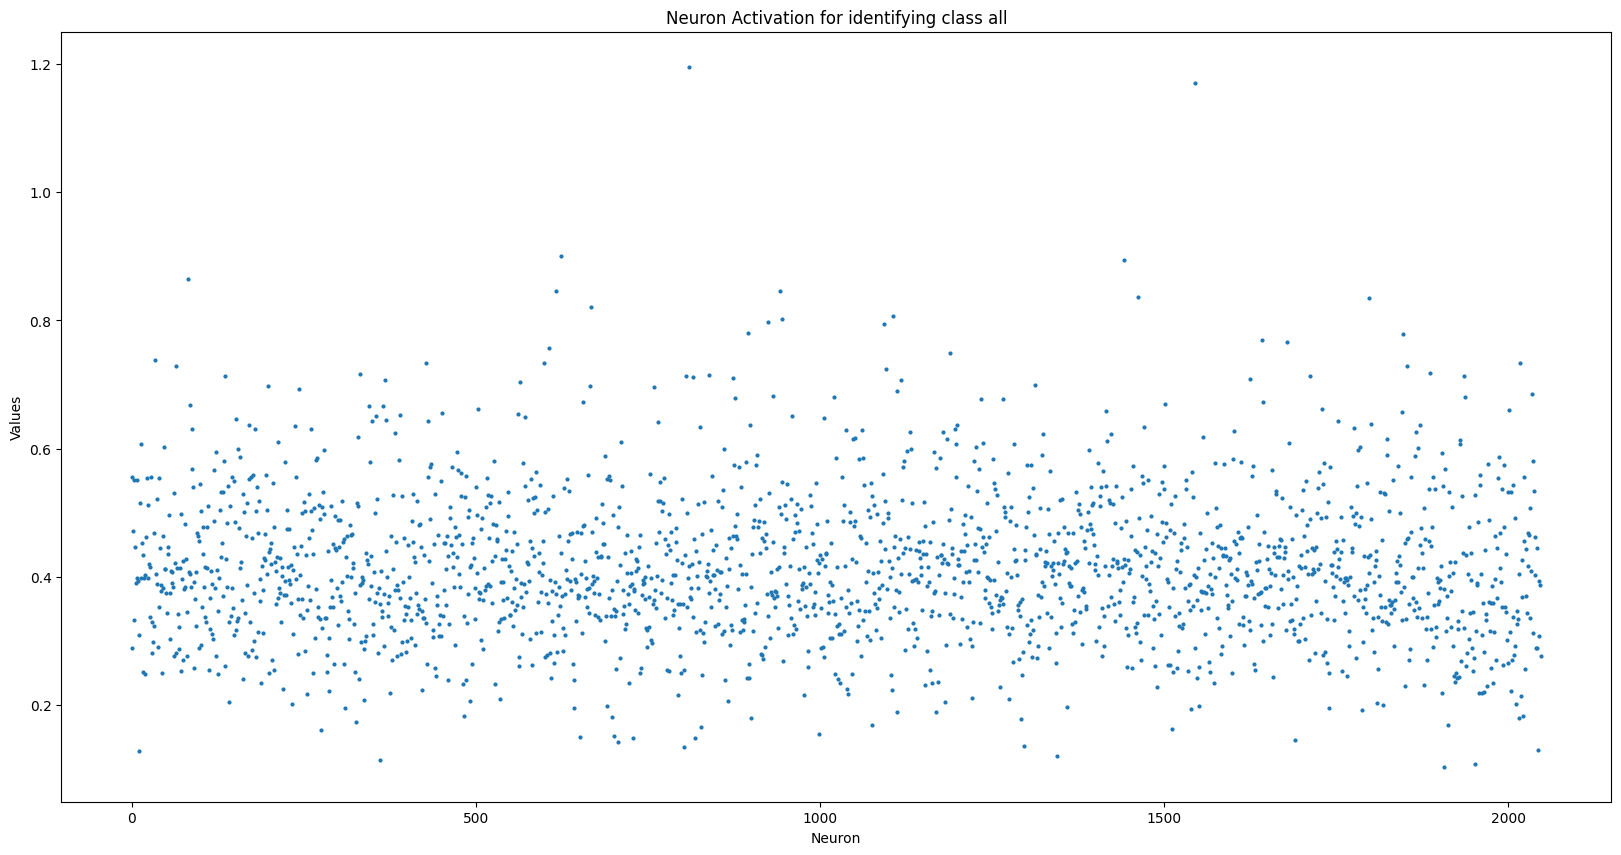

In [908]:

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
def breast_main():
    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    # activ.get_same_class_similarity_matrix(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}_similarity.pkl")
    print(f"activs_stats/{target_save_name}/{label}.pkl")
    

    # neuron_finding.visualize_all_neuron(model_name,target_layer,image_files,label,\
    #                                                                                     10,\
    #                                                                                     f"activs_stats/{target_save_name}",\
    #                                                                                     f"matching_result/{target_save_name}/{label}/",visualize=True)
    os.makedirs(f"matching_result/{target_save_name}/{label}", exist_ok=True)
    draw_bar_chart(label,f"activs_stats/{target_save_name}/{label}.pkl",save_path=f"matching_result/{target_save_name}/{label}",methods=None)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    if os.path.exists(f'predict_result/{model_name}_predictions.csv'):
        print(f'predict_result/{model_name}_predictions.csv exist!')
    else:
        model,_ = models.load(model_name, device)
        model.eval()

        preprocess =transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.22,), (0.08,))
            ])
        results = []
        for image_path in tqdm(image_files):
            image = Image.open(image_path)
            input_tensor = preprocess(image)
            input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
            output = model(input_tensor)
            BM = image_path.split("/")[-2]
            prediction = output.argmax(dim=1).item()
            # 将结果添加到DataFrame中
            results.append({'Image': image_path, 'BM': BM, 'Prediction': prediction})

        # 使用列表创建DataFrame
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'predict_result/{model_name}_predictions.csv', index=False)

    
    return

breast_main()

In [909]:
import torch.nn as nn
from torchvision.transforms import ToPILImage
def breast_sample_explain(i,label,top_number:int=20,importance_matric = "ori_ori"):

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    model,_ = models.load(model_name, device)
    model.eval()

    preprocess =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.22,), (0.08,))
        ])
    

    if isinstance(i,str):
        index = image_files.index(i)
        image_path = i
        i = index
        del index
    else:
        image_path = image_files[i]
    print(image_path)
    
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    
    # 应用BatchNorm
    ori_gradients = data[i, :, 0]
    ori_activations = data[i, :, 2]
    label_dict = get_breast_sample_dict("biomedclip",ori_gradients,ori_activations,"BIRADS",top_number=top_number,importance_matric = importance_matric,only_pos=False)
    
    draw_new( label_dict, data ='BIRADS')
    
    # ##step3:得到分类
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.axis('off')  # 不显示坐标轴
    # plt.tight_layout()
    plt.show()
    # input_tensor = preprocess(image)
    # input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
    # output = model(input_tensor)
    # prediction = output.argmax(dim=1).item()
    # if prediction == 0:
    #     print("It's a liang.")
    # elif prediction == 1:
    #     print("It's e.")
    
    # return sorted_result_dict

In [910]:
def draw(label_dict, data ='BIRADS'):
    # 创建图形和子图
    categories, color_map = get_categories_and_colormap(data)
    organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}

    # 创建图形和子图
    fig = plt.figure(figsize=(10, 25), dpi=300)
    gs = gridspec.GridSpec(len(organized_data), 1, height_ratios=[len(values) for values in organized_data.values()])

    # 绘制每个分类的柱状图，数据按百分比从大到小排序，并确保每个图表的柱子宽度和间距一致
    for idx, (category, values) in enumerate(organized_data.items()):
        # 对每个类别中的标签和百分比按百分比降序排序
        sorted_values = sorted(values.items(), key=lambda x: x[1], reverse=False)
        tags, percentages = zip(*sorted_values)
        
        ax = fig.add_subplot(gs[idx])
        # ax.barh(tags, percentages, height=0.5, color=plt.cm.Paired(np.arange(len(tags))))  # 设置统一的柱子高度为0.5
        # ax.barh(tags, percentages, height=0.5, )
        # ax.set_title(category)
        # ax.set_xlabel('Percentage')
        # ax = fig.add_subplot(gs[idx])
        ax.barh(tags, percentages, height=0.5, color=color_map[category])  # 使用颜色映射设置颜色
        ax.set_title(category)
        ax.set_xlabel('Percentage')

    plt.tight_layout()
    plt.show()



In [911]:
abbreviation_dict = {
    'parallel nodule': 'PARN',
    'non-parallel nodule': 'NPAR',
    'wider-than-tall nodule': 'WTTN',
    'taller-than-wide nodule': 'TTWN',
    'longitudinal nodule': 'LNGN',
    'transverse nodule': 'TRSN',
    'vertically elongated nodule': 'VELN',
    'horizontally elongated nodule': 'HELN',
    'oval shape nodule': 'OSN',
    'round shape nodule': 'RSN',
    'irregular shape nodule': 'IRSN',
    'regular shape nodule': 'RSNN',
    'mixed cystic and solid nodule': 'CCS',
    'spongiform nodule': 'SPGN',
    'solid nodule': 'SON',
    'circular cyst': 'CC',
    'anechoic echo nodule': 'AEN',
    'isoechoic echo nodule': 'IEN',
    'hypoechoic echo nodule': 'HYEN',
    'hyperechoic echo nodule': 'HEEN',
    'heterogeneous echo nodule': 'HETN',
    'anechoic nodule': 'AEN',
    'isoechoic nodule': 'IEN',
    'hypoechoic nodule': 'HYEN',
    'hyperechoic nodule': 'HEEN',
    'heterogeneous nodule': 'HETN',
    'inner anechoic nodule': 'AEN',
    'inner isoechoic nodule': 'IEN',
    'inner hypoechoic nodule': 'HYEN',
    'inner hyperechoic nodule': 'HEEN',
    'inner heterogeneous nodule': 'HETN',
    'punctate calcified nodule': 'PCN',
    'peripheral calcified nodule': 'PCLN',
    'massive area calcified nodule': 'MACN',
    'homogeneously non-calcified nodule': 'HNCN',
    'marginal microlobulated nodule': 'MMN',
    'marginal indistinct nodule': 'MINN',
    'marginal angular nodule': 'MAN',
    'marginal spiculated nodule': 'MSN',
    'marginal distinct nodule': 'MDN',
    'marginal ill-defined nodule': 'MIDN',
    'nodule with no posterior change': 'NPPN',
    'nodule with posterior enhancement': 'NPE',
    'nodule with shadowing': 'NSH',
    'nodule with a combined pattern': 'NCP',
    'middle nodule': 'MN',
    'small nodule': 'SN',
    'large nodule': 'LN'
}

def draw_new(label_dict, data ='BIRADS'):
    label_dict['mixed cystic and solid nodule'] = label_dict['mixed cystic/solid nodule']+label_dict['complex cystic and solid']+label_dict["mixed cystic-solid nodule"]
    # label_dict["parallel nodule"]+=label_dict["wider-than-tall nodule"]+label_dict["transverse nodule"]+label_dict["horizontally elongated nodule"]
    # label_dict["non-parallel nodule"]+=label_dict["taller-than-wide nodule"]+label_dict["longitudinal nodule"]+label_dict["vertically elongated nodule"]
    label_dict["parallel nodule"]=label_dict["horizontally elongated nodule"]
    label_dict["non-parallel nodule"]=label_dict["vertically elongated nodule"]
    
    # del label_dict["outer isoechoic nodule"],label_dict["outer hypoechoic nodule"],label_dict["outer very hypoechoic nodule"],label_dict["outer hyperechoic nodule"],label_dict["outer heterogeneous nodule"]
    for key in ['mixed cystic/solid nodule','complex cystic and solid',"mixed cystic-solid nodule"]:
        del label_dict[key]
    
    for key in ["taller-than-wide nodule","wider-than-tall nodule","transverse nodule","longitudinal nodule","horizontally elongated nodule","vertically elongated nodule"]:
        del label_dict[key]
    label_dict["inner hypoechoic nodule"] += label_dict["inner very hypoechoic nodule"]
    del label_dict['inner very hypoechoic nodule']
    
    # del label_dict['mixed cystic/solid nodule']
    categories, color_map = get_categories_and_colormap(data)
    # Assign colors to each row based on its category
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
    df_filtered = pd.DataFrame(list(label_dict.items()), columns=['description', 'values'])
    
    df_filtered['category_color'] = df_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    assert not df_filtered['category_color'].isna().any(), "在'category_color'列中存在NaN值"
    df_filtered = df_filtered[df_filtered['values']>0]
    df_filtered = df_filtered.sort_values(by=['category_color', 'values'], ascending=[True, False])
    bar_width=1
    positions = range(len(df_filtered['values']))
    # df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    unique_colors = df_filtered['category_color'].unique()
    color_blocks = {color: [] for color in unique_colors}
    last_color = None
    for i, (color, count) in enumerate(zip(df_filtered['category_color'], df_filtered['values'])):
        if color != last_color:
            if last_color is not None:
                color_blocks[last_color][-1].append(i)  # End position of the last block
            color_blocks[color].append([i])  # Start position of the new block
            last_color = color
    color_blocks[last_color][-1].append(i + 1)  # End position of the last block

    
    df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    print(df_filtered)
    
    max_values_by_color = df_filtered.loc[df_filtered.groupby('category_color')['values'].idxmax()]

    # 格式化输出
    formatted_output = max_values_by_color.apply(lambda row: f"{row['description']}({row['values']:.2%})", axis=1).tolist()

    # 打印结果
    for item in formatted_output:
        print(item+",")
    
    plt.figure(figsize=(len(df_filtered['values'])//2, 2.5))
    plt.bar(df_filtered['abbreviation'], df_filtered['values'], color=df_filtered['category_color'],width=0.9, align='center')
    
    # plt.bar(df_filtered['description'], df_filtered['values'], color=df_filtered['category_color'],align='edge')

    # Add shaded regions for each color block
    for color, blocks in color_blocks.items():
        for start, end in blocks:
            plt.axvspan(start-0.45, end-0.55 , color=color, alpha=0.4,linewidth=0)
            
    # # 添加图例到图表
    # plt.legend(handles=legend_handles, title="Categories",framealpha=1.0, facecolor='white', loc='right')

    # plt.title('Number of Neuron per Description')
    plt.xticks(rotation=60, ha='right')
    # plt.subplots_adjust(left=-0.05)
    plt.tick_params(axis='y', which='both', pad=2)
    plt.tick_params(axis='x', which='both', length=0)  # 隐藏x轴的刻度线但保留标签
    plt.tick_params(axis='y', which='both', length=0)  # 隐藏y轴的刻度线    
    plt.xlim(-0.5, len(df_filtered['abbreviation']) - 0.5)
    # 去掉边框
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    # 显示图表
    # plt.savefig(f'layer{number}.pdf', format='pdf', transparent=True)
    plt.show()
    return
    

In [912]:
def get_categories_and_colormap(data:str):
    categories = {
    'Composition': [
        "mixed cystic-solid nodule",
        "mixed cystic/solid nodule",
        "mixed cystic and solid nodule",
        "spongiform nodule",
        "circular cyst",
        "solid nodule",
        "complex cystic and solid",
    ],
    'Echo': [
        "anechoic echo nodule",
        "isoechoic echo nodule",
        "hypoechoic echo nodule",
        "hyperechoic echo nodule",
        "heterogeneous echo nodule",
        "very hypoechoic echo nodule",
        "anechoic nodule",
        "isoechoic nodule",
        "hypoechoic nodule",
        "hyperechoic nodule",
        "heterogeneous nodule",
        "very hypoechoic nodule",
        "inner anechoic nodule",
        "inner isoechoic nodule",
        "inner hypoechoic nodule",
        "inner hyperechoic nodule",
        "inner heterogeneous nodule",
        "inner very hypoechoic nodule"
    ],
    'Shape': [
        "oval shape nodule",
        "round shape nodule",
        "irregular shape nodule",
        "regular shape nodule",
        
    ],
    'Margin': [
        "marginal angular nodule",
        "marginal spiculated nodule",
        "marginal indistinct nodule",
        "marginal microlobulated nodule",
        "marginal smooth nodule",
        "marginal lobulated nodule",
        "marginal ill-defined nodule",
        "marginal well-circumscribed nodule",
        "marginal clear nodule",
        "marginal distinct nodule"
    ],
    'Calcification': [
        "punctate calcified nodule",
        "peripheral calcified nodule",
        "massive area calcified nodule",
        "homogeneously non-calcified nodule"
    ],
    'Ratio': [
        "wider-than-tall nodule",
        "taller-than-wide nodule",
        "vertically elongated nodule",  # 新增
        "horizontally elongated nodule",  # 新增
        "transverse nodule",
        "longitudinal nodule",
        "parallel nodule",
        "non-parallel nodule"
    ],
    'Density': [
        "low-density nodule",
        "equal-density nodule",
        "high-density nodule"
    ],
    'Spatial features':
        [
        "large nodule",
        "middle nodule",
        "small nodule",
        "superior nodule",
        "inferior nodule",
        "left-sided nodule",
        "right-sided nodule"
        ],
    'Imaging features':
        [
            "nodule with posterior feature",
            "nodule with posterior enhancement",
            "nodule with shadowing",
            "nodule with a combined pattern",
            "nodule with no posterior change"
        ]
}
    color_map = {
        'Calcification': '#bdb5e1',
        'Margin': '#FA8072',
        'Ratio':'yellowgreen',
        'Shape': 'skyblue',
        'Echo': '#e9b6be',
        'Composition': '#f9d580',
        'Density':  '#a4d8c2',
        'Spatial features': '#a4d8c2',  # 新增颜色
    'Imaging features': '#a4d8c2'  # 新增颜色
    }
    return categories, color_map

In [913]:
def get_filename(model_name,clipmodel_name):
    if clipmodel_name == "biomedclip":
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_15_44/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_16_44/descriptions.csv"
        # # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_16_27/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_03/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_16_35/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_18_03/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        if model_name == "breast_vit_small_3":
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_small_3_24_09_09_11_20/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_small_3_24_09_09_15_03/descriptions.csv"
        if model_name == "breast_vit_base_3":
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_10_18_04/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_10_18_11/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_11_16_42/descriptions.csv"
            
        if model_name == "breast_vit_large_3":    
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_28/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_31/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_33/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_13_14_43/descriptions.csv"
        if model_name == "breast_rn50_3":
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_10_18_37/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_10_18_43/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_13_15_33/descriptions.csv"
    elif clipmodel_name == "vit":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_15_43/descriptions.csv" ##Vit-L/14
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_21/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_05_15_02/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_16_33/descriptions.csv"
    return filename

In [914]:
def get_breast_sample_dict(clipmodel_name, ori_gradients, ori_activations,label_data="BIRADS", top_number:int=25,importance_matric = "abs_ori", only_pos=False):
    
    ## Standardization
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
        
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]

    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
    elif gradient_type =="sq":
        gradients = ori_gradients**2
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    elif activation_type == "abs":
        activations = np.abs(ori_activations)
    elif activation_type == "pos":
        min_act = np.min(ori_activations)
        if min_act < 0 :
            activations = ori_activations + np.abs(min_act)
        else:
            activations =  ori_activations
    elif activation_type == "sq":
        activations = ori_activations **2
        
    
    
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number,only_pos=only_pos)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    
    
    filename = get_filename(model_name,clipmodel_name)
    df = pd.read_csv(filename)

    # print(filename)
    # unique_descriptions = set()
    sentence_parts = {}
    
    categories, _ = get_categories_and_colormap(label_data)
    for category, tags in categories.items():
        for tag in tags:
            sentence_parts[tag]=0
    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] > 0 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    del sentence_parts
    
    return result_dict

activs_stats/breast_rn50_3model.resnet.layer4[-1]/all.pkl exist!
/export/home/wuyueting/breast_data/BM/3_labelcroped/test/0/FB_1107.jpg
                           description    values category_color abbreviation
28      marginal microlobulated nodule  0.071452        #FA8072          MMN
27          marginal indistinct nodule  0.036503        #FA8072         MINN
34            marginal distinct nodule  0.017447        #FA8072          MDN
26          marginal spiculated nodule  0.011870        #FA8072          MSN
25             marginal angular nodule  0.000921        #FA8072          MAN
44                        large nodule  0.069585        #a4d8c2           LN
46                        small nodule  0.059180        #a4d8c2           SN
53               nodule with shadowing  0.023487        #a4d8c2          NSH
55     nodule with no posterior change  0.008662        #a4d8c2         NPPN
52   nodule with posterior enhancement  0.007812        #a4d8c2          NPE
54      nodule wi

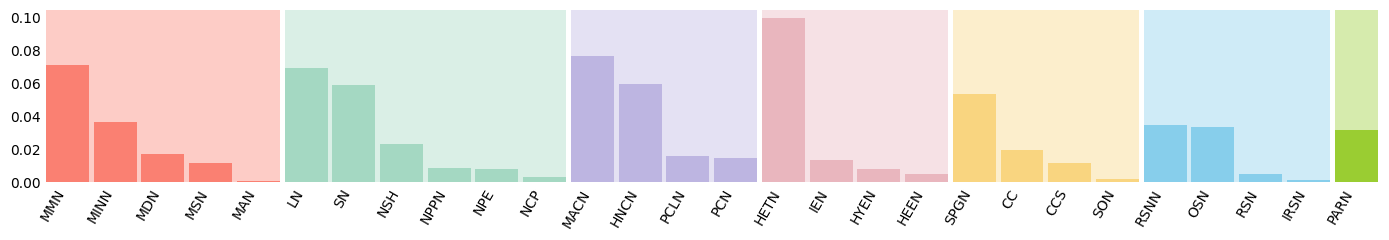

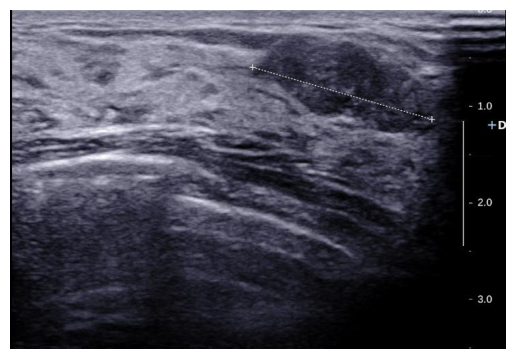

In [915]:
breast_sample_explain("/export/home/wuyueting/breast_data/BM/3_labelcroped/test/0/FB_1107.jpg","all",top_number=600,importance_matric="abs_stn")

## BIRADS3

In [916]:
from sklearn.metrics import roc_curve
def label_auc(label_data="BIRADS",top_number =100, importance_matric = "abs_stn",batch_norm=True, clipmodel = "biomedclip"):

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    tag_csv="/export/home/wuyueting/breast_data/test.csv"
    tag_df = pd.read_csv(tag_csv)
    
    num = tag_df.shape[0]
    
    ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues, shape_trues,density_trues = [], [], [], [], [], [],[]
    ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores, shape_scores,density_scores = [], [], [], [], [], [], []
    
    # if batch_norm== True:
    # print("batch norm is ",batch_norm)
    # batch_norm1 = nn.BatchNorm1d(num_features=384)
    # batch_norm2 = nn.BatchNorm1d(num_features=384)
    # print(np.mean(data[:, :, 2]),np.var(data[:, :, 2]),np.mean(data[:, :, 0]),np.var(data[:, :, 0]))
    # #应用BatchNorm
    # norm_activation = batch_norm1(torch.from_numpy(data[:, :, 2]).cpu().float()).detach().numpy()
    # norm_gradient = batch_norm2(torch.from_numpy(data[:, :, 0]).cpu().float()).detach().numpy()
    # print(np.mean(norm_activation),np.var(norm_activation),np.mean(norm_gradient),np.var(norm_gradient))
    
    for i in range(num):
        image_name = tag_df.iloc[i, 0]
        BM = tag_df.iloc[i, 1]
        image_path = os.path.join("/export/home/wuyueting/breast_data/BM/3_labelcroped/test/",str(BM), image_name)
        # 
        if image_path not in image_files:
            continue
        
        index = image_files.index(image_path)
        # if batch_norm== True:
        #     ori_activations = norm_activation[index,:]
        #     ori_gradients = norm_gradient[index,:]
        # else:
        ori_gradients = data[index, :, 0]
        ori_activations = data[index, :, 2]
        # print(ori_activations,ori_gradients)
        label_dict = get_breast_sample_dict(clipmodel,ori_gradients,ori_activations,label_data,top_number=top_number,importance_matric = importance_matric,only_pos=False)
        categories, _ = get_categories_and_colormap(label_data)
        # print(label_dict)
        organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}
        if not pd.isnull(tag_df.loc[i, 'Ratio']):
            ratio_trues.append(tag_df.loc[i, 'Ratio'])
            ratio_dict = organized_data['Ratio']
            if sum(ratio_dict.values())==0:
                ratio = 0
            else:
                ratio = (ratio_dict["non-parallel nodule"]+ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["vertically elongated nodule"])/sum(ratio_dict.values())
                # ratio = (ratio_dict["taller-than-wide nodule"]+ratio_dict["longitudinal nodule"])/(ratio_dict["transverse nodule"]+ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            # ratio = (ratio_dict["taller-than-wide nodule"])/(+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            
            ratio_scores.append(ratio)
        
        composition_dict = organized_data['Composition']
        if not pd.isnull(tag_df.loc[i, 'Composition']):
            composition_trues.append(tag_df.loc[i, 'Composition'])
            if sum(composition_dict.values())==0:
                composition = 0
            else:
                composition = (composition_dict["solid nodule"]+composition_dict["mixed cystic-solid nodule"]+composition_dict["mixed cystic/solid nodule"])/(sum(composition_dict.values()))
            composition_scores.append(composition)
            
        if not pd.isnull(tag_df.loc[i, 'Margin']):
            margin_trues.append(tag_df.loc[i, 'Margin'])
            margin_dict = organized_data['Margin']
            if sum(margin_dict.values()) == 0:
                margin = 0
            else:
                margin = (sum(margin_dict.values())-margin_dict["marginal well-circumscribed nodule"]-margin_dict["marginal distinct nodule"]-margin_dict["marginal smooth nodule"]-margin_dict["marginal ill-defined nodule"])/sum(margin_dict.values())
            margin_scores.append(margin)
            
        if not pd.isnull(tag_df.loc[i,"Echo"]):
            echo_trues.append(tag_df.loc[i, 'Echo'])
            echo_dict = organized_data["Echo"]
            if (sum(echo_dict.values())) ==0:
                echo = 0
            else:
                echo =  (echo_dict["hypoechoic echo nodule"]+echo_dict["heterogeneous echo nodule"])/(sum(echo_dict.values()))
            echo_scores.append(echo)
            
            # density_dict = organized_data["Density"]
            # density_trues.append(tag_df.loc[i,"Echo"])
            # if sum(density_dict.values())==0:
            #     density = 0
            # else:
            #     density = density_dict["middle-density nodule"]/sum(density_dict.values())
            # density_scores.append(density)
            
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Calcification']
            if sum(cal_dict.values()) == 0:
                cal = 0
            else:
                cal = (sum(cal_dict.values())-cal_dict["homogeneously non-calcified nodule"])/((sum(cal_dict.values())))
            cal_scores.append(cal)
        
        if not pd.isnull(tag_df.loc[i, 'Shape']):
            shape_trues.append(tag_df.loc[i, 'Shape'])
            shape_dict = organized_data['Shape']
            if (shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"]) == 0:
                shape = 0
            else:
                shape =shape_dict["irregular shape nodule"]/(shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"])
            shape_scores.append(shape)
        
        del label_dict, categories, organized_data
            
    # ratio_preds = [0 if x<0.5 else 1 for x in ratio_scores]
    # composition_preds = [0 if x<0.5 else 1 for x in composition_scores]
    # margin_preds = [0 if x<0.5 else 1 for x in margin_scores]
    # echo_preds = [0 if x<0.5 else 1 for x in echo_scores]
    
    # 计算ACC
    scores = [ratio_scores, margin_scores, echo_scores, cal_scores,shape_scores]
    trues = [ratio_trues,  margin_trues, echo_trues, cal_trues, shape_trues]
    categories = ['Ratio',  'Margin', 'Echo', "Calcification", "Shape"]

    # 循环遍历每一组评分和真实值
    for category, true_values, pred_scores in zip(categories, trues, scores):
        # 计算预测值
        # true_values_series = pd.Series(true_values)
        # pred_scores_series = pd.Series(pred_scores)

        # # 检查哪些位置有NaN
        
        # true_values = true_values_series.fillna(0)
        # pred_scores = pred_scores_series.fillna(0)
        
        preds = [0 if x < 0.5 else 1 for x in pred_scores]
        # 计算准确率和AUC
        acc = accuracy_score(true_values, preds)
        auc = roc_auc_score(true_values, pred_scores)
        print(pred_scores)
        # 打印结果
        print(f"{category} Accuracy: {acc:.3f}")
        print(f"{category} AUC: {auc:.3f}")
        # # 计算ROC曲线的坐标点
        # fpr, tpr, thresholds = roc_curve(true_values, pred_scores)

        # # 绘制ROC曲线
        # plt.figure()
        # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('Receiver Operating Characteristic')
        # plt.legend(loc="lower right")
        # plt.show()

In [917]:
# label_auc(label_data="BIRADS",top_number =600, importance_matric = "abs_stn",clipmodel="biomedclip",batch_norm=False)

In [918]:
import matplotlib
from matplotlib.ticker import FuncFormatter
def custom_formatter(y, pos):
    if y < 0:
        return f'{-y:.0e}'  # 负值显示为-1
    else:
        return f'{y:.0e}'  # 正值显示为两位小数
def breast_global_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)

        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = np.sum(elementwise_product, axis=0)/elementwise_product.shape[0]
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    df_clip_filtered = df_clip[df_clip['similarity'] >1]
    df_clip_filtered =df_clip_filtered[['0','1','description']]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('abbr').sum()
    result['abbr'] = result.index
    # result.set_index('abbr', inplace=True)
    


    index = np.arange(len(result))

    # 设置图形的大小
    fig, ax = plt.subplots(figsize=(16, 4))  # 宽度为10英寸，高度为6英寸
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   
    # 设置条形宽度和偏移量
    bar_width = 0.35  # 条形的宽度
    offset = 0.17     # 每组条形之间的偏移量
    # 绘制 '1' 列的条形图
    # ax.bar(index, np.array(result['1']),label='Malignant', facecolor='#F39808', edgecolor='black') ##F0907E

    # # 绘制 '0' 列的条形图，使用负值使其显示在左侧
    # ax.bar(index, 1*np.array(result['0']), label='Benign', facecolor='#91BFFA', edgecolor='black')
    # ax.axhline(0, color='black', linewidth=1, linestyle='-')
    ax.bar(index - offset, np.array(result['1']), width=bar_width, label='Malignant', facecolor='#F39808', edgecolor='black')

    # 绘制 '0' 列的条形图（良性），正值
    ax.bar(index + offset, np.array(result['0']), width=bar_width, label='Benign', facecolor='#91BFFA', edgecolor='black')

    ax.axhline(0, color='black', linewidth=1, linestyle='-')
    # 设置 x 轴的显示范围
    ax.set_xlim(-1, len(result))

    # 设置 x 轴的刻度标签
    ax.set_xticks(index)
    ax.set_xticklabels(result.index, rotation=60)
    
    # max_val = max(max(result['1']), -min(result['0']))  # 找到最大的绝对值
    # y_ticks = np.linspace(-max_val, max_val, num=10)  # 创建10个刻度
    # ax.set_yticks(y_ticks)

    # # 使用 FuncFormatter 格式化 y 轴标签为科学计数法
    # def sci_format(x, pos):
    #     return f"{abs(x):.1e}"

    # formatter = FuncFormatter(sci_format)
    # ax.yaxis.set_major_formatter(formatter)
    ax.legend()
    fig.patch.set_alpha(0.0)
    # ax.set_facecolor('none')
    # 显示图表
    plt.show()
    fig.savefig('test.png', bbox_inches='tight',transparent = True)
# breast_global_explain()   

             0         1  expression_difference
abbr                                           
CCS   0.000026  0.000031               4.334775
MINN  0.000024  0.000030               3.809655
MSN   0.000008  0.000011               2.741818
MMN   0.000109  0.000113               2.180304
MDN   0.000004  0.000005               1.254127
SN    0.000066  0.000037             -14.576911
NPAR  0.000037  0.000016             -17.467669
HELN  0.000076  0.000027             -41.014261
SPGN  0.000143  0.000063             -84.889549
LNGN  0.000281  0.000103            -170.825805


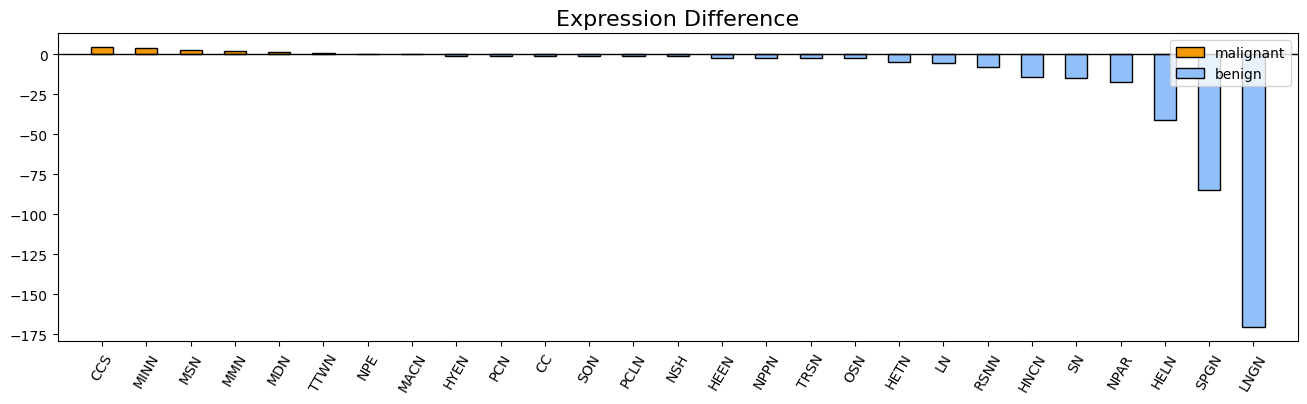

In [919]:
def breast_global_explain_new():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)

        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = np.sum(elementwise_product, axis=0)/elementwise_product.shape[0]
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    # print(df_clip)
    df_clip["expression_difference"] = np.log(np.array(df_clip['1']) / (np.array(df_clip['0'])))
    
    df_clip_filtered = df_clip[df_clip['similarity'] >1]
    df_clip_filtered =df_clip_filtered[['0','1','description',"expression_difference"]]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('abbr').sum()
    result['abbr'] = result.index
    result = result.sort_values(by='expression_difference', ascending=False)
    # result["expression_difference"]= np.log(np.array(result['1']) / (np.array(result['0']) + 1e-20))
    
    result_sorted = result.sort_values(by='expression_difference', ascending=False)

    # 分别筛选出大于0和小于0的前5名
    top_positive = result_sorted[result_sorted['expression_difference'] > 0].head(5)
    top_negative = result_sorted[result_sorted['expression_difference'] < 0].tail(5)

    # 合并这两个 DataFrame
    top_results = pd.concat([top_positive, top_negative])[['0','1','expression_difference']]
    print(top_results)

    fig, ax = plt.subplots(figsize=(16, 4))  # 宽度为16英寸，高度为4英寸
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # 设置条形宽度
    bar_width = 0.5  # 条形的宽度

    # # 绘制 'expression_difference' 列的条形图
    # index = np.arange(len(top_results))
    # bars = ax.bar(index, top_results['expression_difference'], width=bar_width, color='blue', edgecolor='black')

    # # # 设置颜色和标签
    # for bar, val in zip(bars, top_results['expression_difference']):
    #     if val > 0:
    #         bar.set_color('#F39808')
    #         bar.set_label('malignant')
    #         bar.set_edgecolor('black')
    #     else:
    #         bar.set_color('#91BFFA')
    #         bar.set_label('benign')
    #         bar.set_edgecolor('black')
    # # malignant_bars = ax.bar(index - bar_width / 2, result['expression_difference'], width=bar_width, label='Malignant', color='#F39808', edgecolor='black')
    # # benign_bars = ax.bar(index + bar_width / 2, result['expression_difference'], width=bar_width, label='Benign', color='#91BFFA', edgecolor='black')
    # ax.axhline(0, color='black', linewidth=1, linestyle='-')

    # # 设置 x 轴的显示范围
    # ax.set_xlim(-1, len(top_results))

    # # 设置 x 轴的刻度标签
    # ax.set_xticks(index)
    # ax.set_xticklabels(top_results.index, rotation=60)


    # # 添加图例
    # ax.legend(handles=[bars[0],bars[-1]], loc='upper right')
    # # ax.legend(loc='upper right')
    # # 显示图形
    # plt.show()
    
    # 绘制 'expression_difference' 列的条形图
    index = np.arange(len(result))
    bars = ax.bar(index, result['expression_difference'], width=bar_width, color='blue', edgecolor='black')

    # # 设置颜色和标签
    for bar, val in zip(bars, result['expression_difference']):
        if val > 0:
            bar.set_color('#F39808')
            bar.set_label('malignant')
            bar.set_edgecolor('black')
        else:
            bar.set_color('#91BFFA')
            bar.set_label('benign')
            bar.set_edgecolor('black')
    # malignant_bars = ax.bar(index - bar_width / 2, result['expression_difference'], width=bar_width, label='Malignant', color='#F39808', edgecolor='black')
    # benign_bars = ax.bar(index + bar_width / 2, result['expression_difference'], width=bar_width, label='Benign', color='#91BFFA', edgecolor='black')
    ax.axhline(0, color='black', linewidth=1, linestyle='-')

    # 设置 x 轴的显示范围
    ax.set_xlim(-1, len(result))
    ax.set_title('Expression Difference', fontsize=16)
    # 设置 x 轴的刻度标签
    ax.set_xticks(index)
    ax.set_xticklabels(result.index, rotation=60)


    # 添加图例
    ax.legend(handles=[bars[0],bars[-1]], loc='upper right')
    # ax.legend(loc='upper right')
    # 显示图形
    plt.show()

    fig.savefig('test.png', bbox_inches='tight',transparent = True)
breast_global_explain_new()   